Questions 


### Transaction Table *
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

### Identity Table *
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

I have decided to exclude all Vxxx features from the analysis as we do not know what they are or how they were created.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

In [2]:
dataset_path = '../datasets/fraud_datasets/'


# sample_submission_df = pd.read_csv(f'{dataset_path}sample_submission.csv')

train_transaction_df = pd.read_csv(
    f'{dataset_path}train_transaction.csv', usecols=[i for i in range(55)])
test_transaction_df = pd.read_csv(
    f'{dataset_path}test_transaction.csv', usecols=[i for i in range(54)])

train_id_df = pd.read_csv(f'{dataset_path}train_identity.csv')
test_id_df = pd.read_csv(f'{dataset_path}test_identity.csv')

After importing our raw datasets, they need to be merged by TransactionID's.

<b>(Note: throughout this notebook, it will be important to delete any dataframes that will not be used again as they take up space in memory and slow our machine down.)</b>

In [3]:
train = train_transaction_df.merge(train_id_df, on='TransactionID', how='left')
test = test_transaction_df.merge(test_id_df, on='TransactionID', how='left')

# Renaming columns for better description
names = {
    'addr1': 'billing zipcode',
    'addr2': 'country codes',
    'P_emaildomain': 'Purchaser_emaildom',
    'R_emaildomain': 'Retailer_email.dom'
}

train.rename(columns=names, inplace=True)
test.rename(columns=names, inplace=True)

In [4]:
test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3663554,18403323,57.950,W,12839,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3663555,18403350,87.000,W,16560,476.0,150.0,visa,126.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3663556,18403387,390.000,W,15066,170.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3663557,18403405,103.950,W,2803,100.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3663558,18403416,117.000,W,12544,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
del train_transaction_df, train_id_df, test_transaction_df, test_id_df

In [6]:
print(f'Training data has {train.shape[0]} rows and {train.shape[1]} columns')
print(f'Training data has {test.shape[0]} rows and {test.shape[1]} columns')

Training data has 590540 rows and 95 columns
Training data has 506691 rows and 94 columns


In [7]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [8]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA
Visually exploring the dataset it important for familiarizing ourselves with it and trying to better understand the data before complex analysis is undertaken.

### Data
First, lets get an overview of the features and their data types.

<b>(Note: due to the large output the following script produces, the output can be found in the eda_output folder in under feature_overview.txt)</b>

In [9]:
eda_output_path = 'eda_output/'
feat_over_file = 'feature_overview.txt'

if os.path.exists(f'{eda_output_path}{feat_over_file}'):
    os.remove(f'{eda_output_path}{feat_over_file}')

with open(f'{eda_output_path}{feat_over_file}', 'a') as overview_file:
    for col, values in train.iteritems():
        overview_file.write(f'{col}: {values.nunique()} ({values.dtypes})\n')
        overview_file.write(str(values.unique()[:100]))
        overview_file.write(
            '\n\n###########################################################\n\n')

When we examine the feature_overview.txt file, we notice that there are many continuous features and some categorical features.

### Missing Values

In [10]:
train_contains_na = train.isna().any().sum()
test_contains_na = test.isna().any().sum()

In [11]:
print(f'{train_contains_na} out of {len(train.columns)} columns contain missing values in the train data')
print(f'{test_contains_na} out of {len(test.columns)} columns contain missing values in the test data')

75 out of 95 columns contain missing values in the train data
89 out of 94 columns contain missing values in the test data


In [12]:
# Calculating percentage of missing values in each column
train_missing_values = train.isna().mean().round(2)
test_missing_values = test.isna().mean().round(2)

# Keeping only columns that contain more than 50% missing values
train_missing_values_5 = train_missing_values[train_missing_values.values > 0.05]
test_missing_values_5 = test_missing_values[test_missing_values.values > 0.05]

In [13]:
print(f'{len(train_missing_values_5)} out of {len(train.columns)} columns in the train data contain more than 50% missing values')
print(f'{len(test_missing_values_5)} out of {len(test.columns)} columns in the test data contain more than 50% missing values')

69 out of 95 columns in the train data contain more than 50% missing values
67 out of 94 columns in the test data contain more than 50% missing values


As we can see there are a large number of missing values in the data.

In [14]:
# Keeping only columns that contain more than 50% missing values
train_missing_values_70 = train_missing_values[train_missing_values.values > 0.75]
test_missing_values_70 = test_missing_values[test_missing_values.values > 0.75]

In [15]:
print(f'{len(train_missing_values_70)} out of {len(train.columns)} columns in the train data contain more than 75% missing values')
print(f'{len(test_missing_values_70)} out of {len(test.columns)} columns in the test data contain more than 75% missing values')

49 out of 95 columns in the train data contain more than 75% missing values
27 out of 94 columns in the test data contain more than 75% missing values


### Target Feature: isFraud

In [16]:
isFraud = 'isFraud'

In [17]:
# Plot Function
def PlotFunction(df, feature, title, xLable, yLabel, vertical=False, percentLabels=False, size=[10, 7]):
    plt.style.use('ggplot')

    f = plt.figure(figsize=size)
    ax = f.add_subplot(1, 1, 1)
    ax.title.set_text(title)
    ax.set_ylabel(yLabel)
    ax.set_xlabel(xLable)

    plot = ax.bar([str(i) for i in df[feature].value_counts(dropna=False, normalize=True).index],
                  df[feature].value_counts(dropna=False, normalize=True), 0.40,
                  color=['cornflowerblue', 'darkorange', 'green', 'brown', 'black'])
    if vertical:
        plt.xticks(rotation=90)

    # Add counts above the two bar graphs
    if percentLabels:
        percentages = (df[feature].value_counts(
            dropna=False, normalize=True)*100).round(3)
        i = 0
        for rect in plot:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height,
                     f'{percentages[i]}%', ha='center', va='bottom')
            i += 1

In [18]:
print(f'These are the two types of values for fraud: {train[isFraud].unique()}')

These are the two types of values for fraud: [0 1]


In [19]:
print(f'isFraud contains {train[isFraud].isna().any() * 1} missing values')

isFraud contains 0 missing values


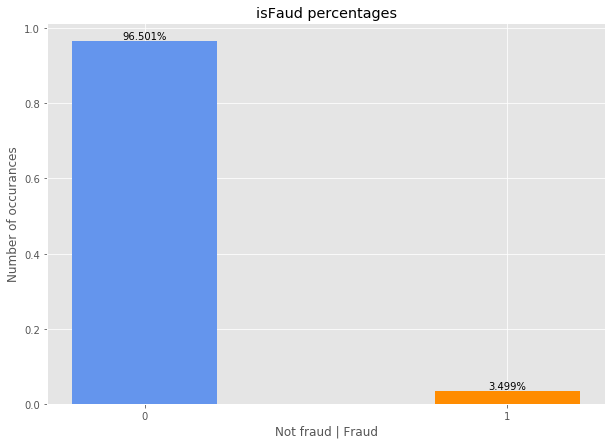

In [20]:
### 'Fraud' Feature
PlotFunction(train, isFraud, 'isFaud percentages', 'Not fraud | Fraud', 'Number of occurances', percentLabels=True)    

A visual examination of the graph reveals an imbalance in the number of fraudulent transactions.

To correct this imbalanace, the use of a sampling method such as SMOTE or oversampling will be needed.

### Exploring the Features

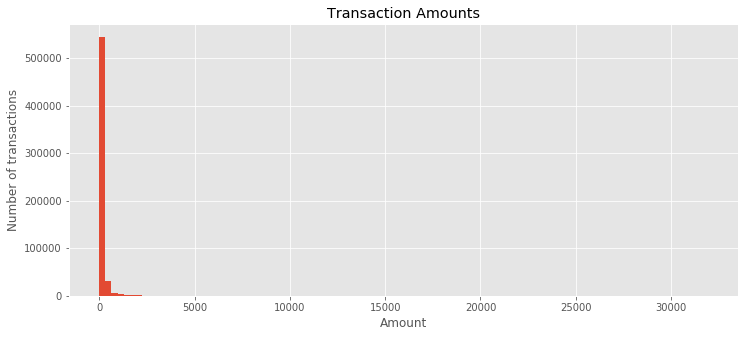

In [21]:
# 'TransactionAmt' feature
plt.figure(figsize=[12, 5])
plt.title('Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of transactions')
_ = plt.hist(train['TransactionAmt'], bins=100)

There is a clear right skew to this data. I will try a log transformation to reduce this effect.

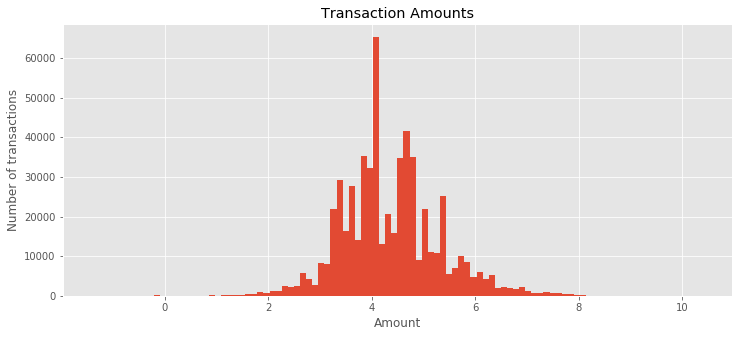

In [22]:
# 'TransactionAmt' feature
plt.figure(figsize=[12, 5])
plt.title('Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of transactions')
_ = plt.hist(train['TransactionAmt'].apply(np.log), bins=100)

'TransactionAmt' now shows a normal distribution, we can separate which transactions were fraudulent and compare whether they are larger.

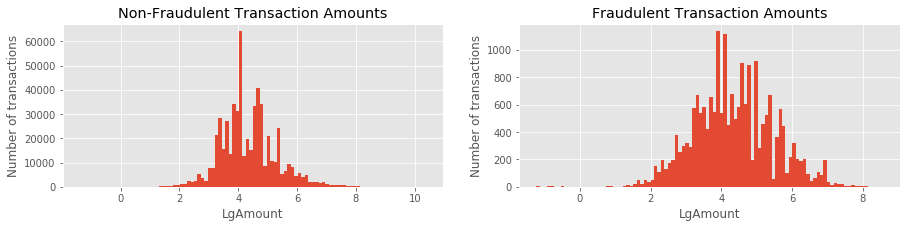

In [23]:
# 'TransactionAmt' feature
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

# Not Fraud
ax1.title.set_text('Non-Fraudulent Transaction Amounts')
ax1.set_xlabel('LgAmount')
ax1.set_ylabel('Number of transactions')
_ = ax1.hist(train['TransactionAmt']
             [train['isFraud'] == 0].apply(np.log), bins=100)

# Fraud
ax2.title.set_text('Fraudulent Transaction Amounts')
ax2.set_xlabel('LgAmount')
ax2.set_ylabel('Number of transactions')
_ = ax2.hist(train['TransactionAmt']
             [train['isFraud'] == 1].apply(np.log), bins=100)

From this, we can see that the fraudulent transaction amounts seem to be higher on average.

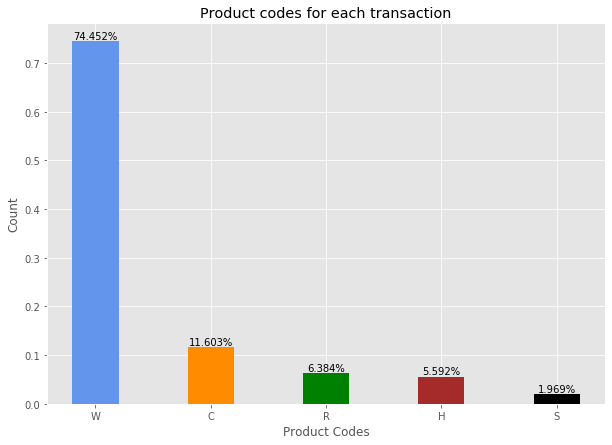

In [24]:
### 'ProductCD' feature
PlotFunction(train, 'ProductCD', 'Product codes for each transaction', 'Product Codes', 'Count', percentLabels=True)

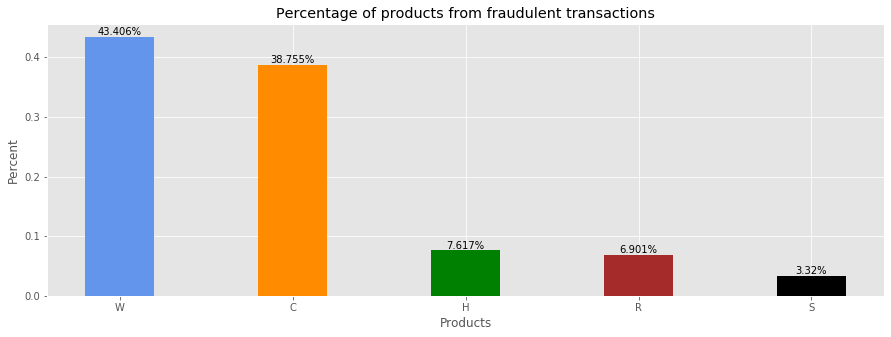

In [25]:
f = plt.figure(figsize=[15, 5])
ax = f.add_subplot(1, 1, 1)
ax.title.set_text('Percentage of products from fraudulent transactions')
ax.set_ylabel('Percent')
ax.set_xlabel('Products')

plot = ax.bar([str(i) for i in train['ProductCD'][train['isFraud'] == 1].value_counts(dropna=False, normalize=True).index],
              train['ProductCD'][train['isFraud'] == 1].value_counts(
                  dropna=False, normalize=True), 0.40,
              color=['cornflowerblue', 'darkorange', 'green', 'brown', 'black'])

# Add counts above the two bar graphs
percentages = (train['ProductCD'][train['isFraud'] == 1].value_counts(
    dropna=False, normalize=True)*100).round(3)
i = 0
for rect in plot:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height,
             f'{percentages[i]}%', ha='center', va='bottom')
    i += 1

There are two main products involved with fraululent transactions, 'W' and 'C'.

In [26]:
# 'card1' feature
print('Number of unique values:', len(train['card1'].unique()))
train['card1'].value_counts(dropna=False, normalize=True).head()

Number of unique values: 13553


7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
Name: card1, dtype: float64

In [27]:
### 'card2' feature
print('Number of unique values:', len(train['card2'].unique()))
train['card2'].value_counts(dropna=False, normalize=True).head()

Number of unique values: 501


321.0    0.082865
111.0    0.076525
555.0    0.071113
490.0    0.064593
583.0    0.036920
Name: card2, dtype: float64

'card1' & 'card2 have a large number of unique values with no clear dominating catagory.

In [28]:
### 'card3' feature
print('Number of unique values:', len(train['card3'].unique()))
train['card3'].value_counts(dropna=False, normalize=True).head()

Number of unique values: 115


150.0    0.882729
185.0    0.095414
106.0    0.002660
NaN      0.002650
146.0    0.002120
Name: card3, dtype: float64

'card3' has 88% of its values being 150.

In [29]:
### 'card5' feature
print('Number of unique values:', len(train['card5'].unique()))
train['card5'].value_counts(dropna=False, normalize=True).head()

Number of unique values: 120


226.0    0.502161
224.0    0.138031
166.0    0.096759
102.0    0.049285
117.0    0.043928
Name: card5, dtype: float64

'card5' has 50% of its values being 226.

Number of unique values: 5


visa                0.651551
mastercard          0.320414
american express    0.014102
discover            0.011263
NaN                 0.002670
Name: card4, dtype: float64

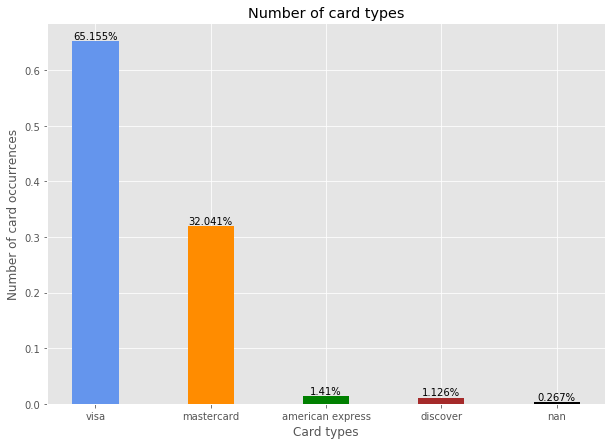

In [30]:
### 'card4' feature
PlotFunction(train, 'card4', 'Number of card types', 'Card types', 'Number of card occurrences', percentLabels=True)

print('Number of unique values:', len(train['card4'].unique()))
train['card4'].value_counts(dropna=False, normalize=True).head(10)

'visa' cards are have the highest use in this dataset at 65%.

Number of unique values: 5


debit              0.744976
credit             0.252288
NaN                0.002660
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64

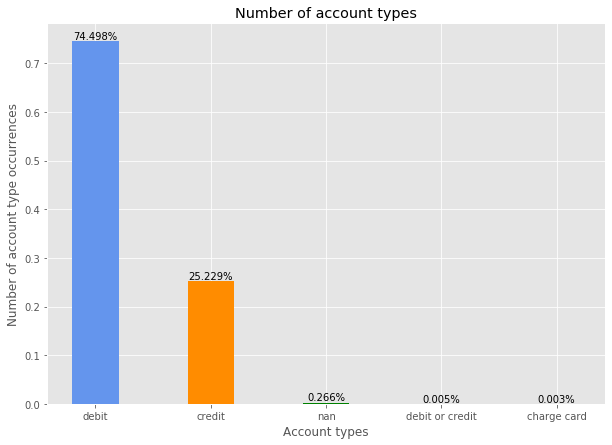

In [31]:
### 'card6' feature
PlotFunction(train, 'card6', 'Number of account types', 'Account types', 'Number of account type occurrences', percentLabels=True)

print('Number of unique values:', len(train['card6'].unique()))
train['card6'].value_counts(dropna=False, normalize=True).head(10)

'debit' account types have the highest use in this dataset at 75%.

In [32]:
### 'billing zipcode' feature
print('Number of unique values:', len(train['billing zipcode'].unique()))
train['billing zipcode'].value_counts(dropna=False, normalize=True).head(10)

Number of unique values: 333


NaN      0.111264
299.0    0.078462
325.0    0.072393
204.0    0.071155
264.0    0.067514
330.0    0.044513
315.0    0.039079
441.0    0.035268
272.0    0.034106
123.0    0.027272
Name: billing zipcode, dtype: float64

In [33]:
### 'country codes' feature
print('Number of unique values:', len(train['country codes'].unique()))
train['country codes'].value_counts(dropna=False, normalize=True).head()

Number of unique values: 75


87.0    0.881365
NaN     0.111264
60.0    0.005222
96.0    0.001080
32.0    0.000154
Name: country codes, dtype: float64

It seems that 88% of transactions have come from <a href='https://en.wikipedia.org/wiki/List_of_UIC_country_codes'>France</a>. 11% of transactions that do not have a country code, however, it is unlikely that all of these transactions belong to the one country.

Number of unique values: 60


gmail.com        0.386688
yahoo.com        0.170918
NaN              0.159949
hotmail.com      0.076625
anonymous.com    0.062651
Name: Purchaser_emaildom, dtype: float64

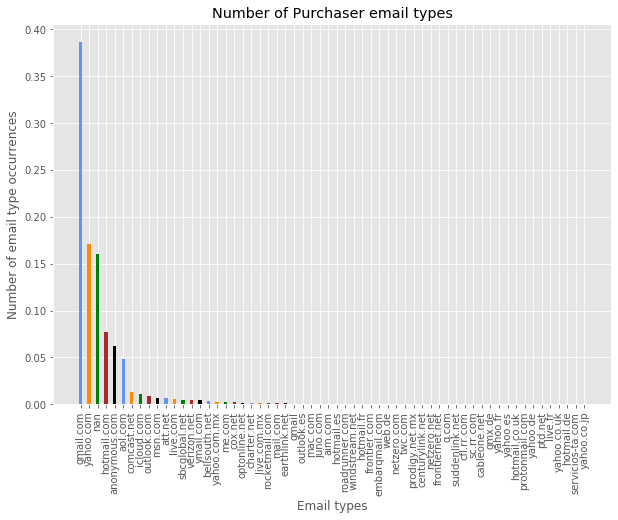

In [34]:
### 'Purchaser Email' feature
PlotFunction(train, 'Purchaser_emaildom', 'Number of Purchaser email types', 'Email types',
             'Number of email type occurrences', vertical=True, percentLabels=False)

print('Number of unique values:', len(train['Purchaser_emaildom'].unique()))
train['Purchaser_emaildom'].value_counts(dropna=False, normalize=True).head()

'gmail.com' accounts for 38% of the emails tied with purchaser transactions.

Number of unique values: 60


NaN              0.767516
gmail.com        0.096771
hotmail.com      0.046583
anonymous.com    0.034763
yahoo.com        0.020053
Name: Retailer_email.dom, dtype: float64

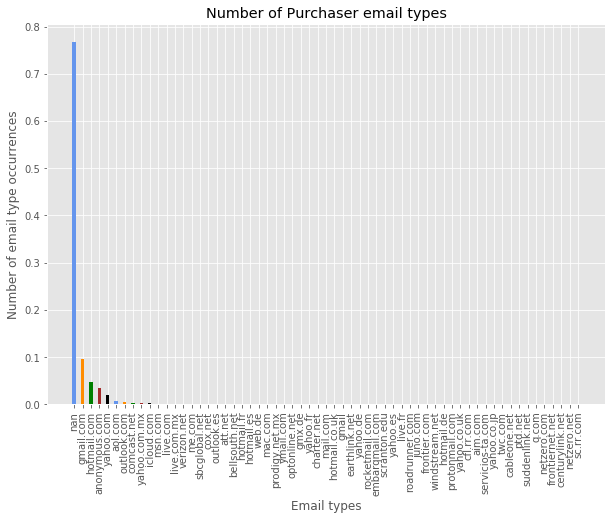

In [35]:
# 'Purchaser Email' feature
PlotFunction(train, 'Retailer_email.dom', 'Number of Purchaser email types', 'Email types',
             'Number of email type occurrences', vertical=True, percentLabels=False)

print('Number of unique values:', len(train['Purchaser_emaildom'].unique()))
train['Retailer_email.dom'].value_counts(dropna=False, normalize=True).head()

'gmail.com' accounts for 77% of the emails tied with retailer transactions.

In [36]:
feature_names = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']

In [37]:
feature_names = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']

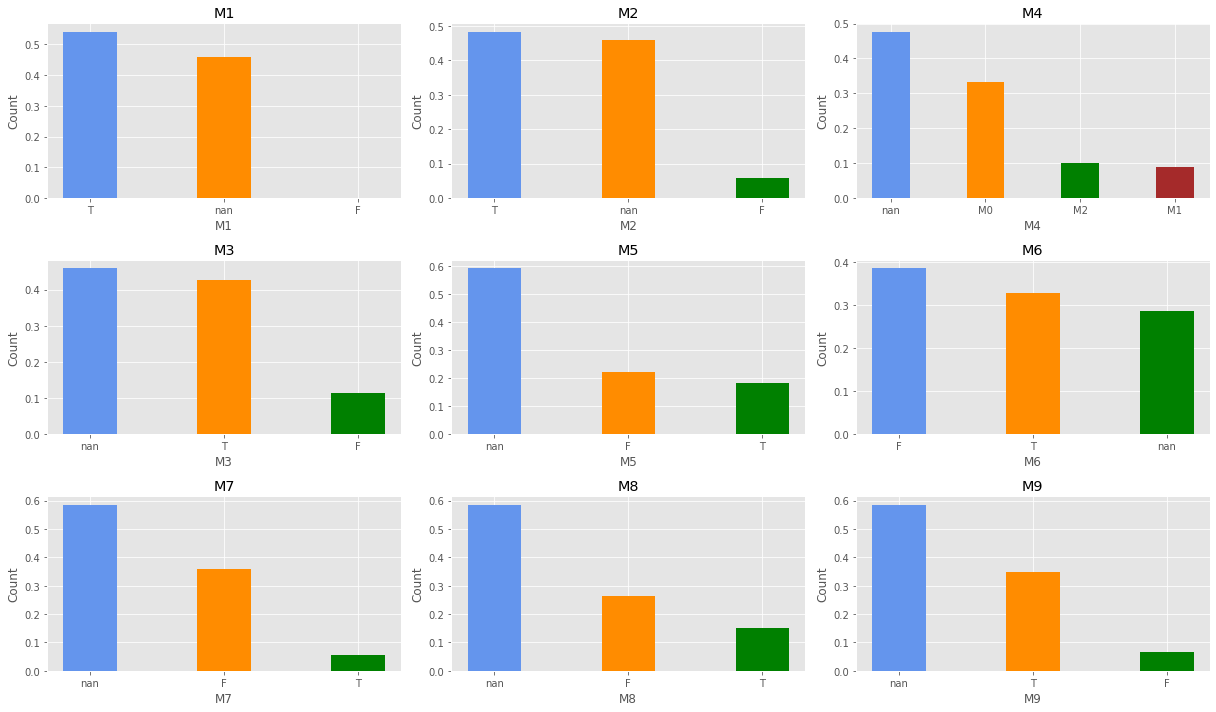

In [38]:
feature_names = ['M1', 'M2', 'M4', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

fig, axes = plt.subplots(3, 3, figsize=(17, 10))

j = 0
for row in axes:
    for ax in row:
        ax.set_title(feature_names[j])
        ax.set_ylabel('Count')
        ax.set_xlabel(feature_names[j])

        plot = ax.bar([str(i) for i in train[feature_names[j]].value_counts(dropna=False, normalize=True).index],
                      train[feature_names[j]].value_counts(
                          dropna=False, normalize=True), 0.40,
                      color=['cornflowerblue', 'darkorange', 'green', 'brown', 'black'])
        j += 1

plt.tight_layout()

In [39]:
feature_names = ['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


### Handling Missing Values
Due to the large number of NaN values our dataframes contain, it is critical that they are replaced with a meaningful placeholder.

In [40]:
y = train['isFraud'].copy()
X = train.drop('isFraud', axis=1)

del train

Features that consist of more than 5% missing values will be excluded as the potential effect of bias may become to large.

In [41]:
test.drop(test_missing_values_5.index, axis=1, inplace=True)
X.drop(train_missing_values_5.index, axis=1, inplace=True)

In [43]:

# Finding feature with missing columns
test_missing_columns = test.columns[test.isna().any()].tolist()

# Categorical boolean mask
test_categorical_feature_mask = test.dtypes==object
# Filter categorical columns using mask
test_categorical_cols = test.columns[test_categorical_feature_mask].tolist()


# Seperating categorical and numerical features
test_cat_feat_contain_nan = []
for feat in test_categorical_cols:
    if feat in test_missing_columns:
        test_cat_feat_contain_nan.append(feat)
        test_missing_columns.remove(feat)
        
        
# Mean imputation
test[test_missing_columns] = test[test_missing_columns].fillna(test[test_missing_columns].mean())
# Mode imputation
test[test_cat_feat_contain_nan] = test[test_cat_feat_contain_nan].fillna(test[test_cat_feat_contain_nan].mode())


test[test_categorical_cols] = test[test_categorical_cols].astype('str')

le = LabelEncoder()
test[test_categorical_cols] = test[test_categorical_cols].apply(lambda col: le.fit_transform(col))

In [44]:
# Finding feature with missing columns
missing_columns = X.columns[X.isna().any()].tolist()

# Categorical boolean mask
categorical_feature_mask = X.dtypes==object
# Filter categorical columns using mask
categorical_cols = X.columns[categorical_feature_mask].tolist()

In [45]:
# Seperating categorical and numerical features
cat_feat_contain_nan = []
for feat in categorical_cols:
    if feat in missing_columns:
        cat_feat_contain_nan.append(feat)
        missing_columns.remove(feat)

In [46]:
# Mean imputation
X[missing_columns] = X[missing_columns].fillna(X[missing_columns].mean())

In [47]:
# Mode imputation
X[cat_feat_contain_nan] = X[cat_feat_contain_nan].fillna(X[cat_feat_contain_nan].mode())

### Feature Selection

#### Selecting Features

In [48]:

X[categorical_cols] = X[categorical_cols].astype('str')

le = LabelEncoder()
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
# X[categorical_cols] = X[categorical_cols].astype('int')

In [49]:

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X, y)
# featureScores = pd.DataFrame(fit.scores_, columns=['Score'])
# featureScores['Specs'] = X.columns

# # Returns the best 10 features
# features = np.array(featureScores.nlargest(10, 'Score')['Specs']).tolist()

#### SMOTE or Oversampling

#### Train/test split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

#### Place holder

#### Impute

## Adaboost

#### Default Variables

In [51]:
# features = ['TransactionAmt', 'TransactionDT', 'card1', 'card2']
features = X.columns
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler().fit(X_train[features])
# x = scaler.transform(X_train[features])

In [52]:
def calculate_decision_stump_efficient(data, label, feature, weight):

    Tp=np.float64(0); #T+ total sum of positive examples weights
    Tn=np.float64(0) #T- total sum of negative examples weights
    Sp=np.float64(0) #S+ sum of positive weights below the cuurent threshold
    Sn=np.float64(0) #S- sum of negative weights below the current threshold
    error1=np.float64(0)
    error2=np.float64(0)
    min_error=np.float64(2.0) 
    min_thresh=np.float64(0) 
    direction=1
    N = len(data[:,feature])
    
    y = np.zeros(N, dtype=np.int64)
    
    #get all positive weights    
    temp  = (label == 1)
    temp = np.int64(temp)
    Tp = np.sum(temp * weight)
    
    #get all negative weights  
    temp  = (label == -1)
    temp = np.int64(temp)
    Tn = np.sum(temp * weight)
    
    #sort feature values
    sorted_labels = data[:, feature].argsort()
    sorted_vector =  data[sorted_labels]

    length = len(sorted_vector)
    for i in range(length):

        #RIGHT DIRECTION THRESHOLD
        #error1 is the sum of positives up to that point + total negatives minus the sum of negatives so far
        error1 = Sp + (Tn - Sn) 
        if label[sorted_labels[i]] == -1 : 
            Sn = Sn +  weight[sorted_labels[i]]
        else :
            Sp = Sp + weight[sorted_labels[i]]
            
        #LEFT DIRECTION THRESHOLD
        error2 = Sn + (Tp - Sp) 
        
        if(min_error > error1) :
            min_error = error1
            min_thresh = sorted_vector[i, feature]
            direction = 1
        if(min_error > error2) :
            min_error = error2
            min_thresh = sorted_vector[i, feature]
            direction = -1           
    
    return min_thresh, direction, min_error
       

In [53]:
def classify_dataset_against_weak_classifier(x, thresh, direction):
    
    classification = np.zeros(len(x))
    
    #classifiy all samples based on the last feature
    #get actual classification
    for i in range(len(x)):
        if direction == -1:
            if x[i] < thresh: classification[i] = 1
            else : classification[i] = -1
        else:
            if x[i] < thresh: classification[i] = -1
            else : classification[i] = 1    
        
                
    return classification 

In [54]:
# X: an two dimensional np.array of independent features values.
# Y: an one dimensional np.array of actual target values. Values either {-1,1}.
# T: number of boosting arounds.
# features: a list of feature names.
# learn_rate: the learning rate used to calculate alpha[t].
def fit(X, Y, T, features, learn_rate):
    
    h=np.zeros([T,3], dtype=np.float64)
    alphas = np.zeros(T, dtype=np.float64)
    err = np.ones(T, dtype=np.float64) * np.inf
    weight=np.ones(len(X), dtype=np.float64)/len(X)
    
    for t in range(T):
        # Iterate through every feature in our training data.
        for feature in range(len(features)):
            weighted_error = np.float64(0)

            # Build our decision stump.
            threshold, sign, weighted_error = calculate_decision_stump_efficient(X, Y, feature, weight)

            # Select the best model and feature that produces the lowest model error
            if weighted_error < err[t] :
                err[t] = weighted_error
                h[t][0] = threshold
                h[t][1] = feature
                h[t][2] = sign

        # Calculate alpha value based
        alphas[t] = learn_rate * np.log( (1.0 - err[t])/err[t])
        
        # Make a prediction using t decision stump classifier
        classification = classify_dataset_against_weak_classifier(X[:, int(h[t][1])], h[t][0], h[t][2] )

        # Update the weights based on what was not correctly, some alpha value and a learning rate
        weight *= np.exp(-1.0*alphas[t]*classification*labels)
        
        # Normalize the weights distribution
        weight = weight / np.sum(weight)
        
    h = np.append(h,np.reshape(alphas,(-1,1)), axis=1)
    return h

In [55]:
def predict(data_arr, boost_classif):
    
    classification_arr = np.zeros((len(data_arr),1))
    
    for idx, thresh, feat, sign, alpha in boost_classif.itertuples():
        ht1 = np.sign(data_arr[:, int(feat)] - thresh) * sign
        classification_arr += alpha*np.reshape(ht1,(-1,1))

    classification_arr = np.where(classification_arr >= 0,1,-1)
    
    return classification_arr

In [56]:
def sum_classifier_votes_for_each_sample(dataset, classifier_df):
    classification1 = np.float64(0)
    neg = np.float64(0)
    pos = np.float64(0)
    for idx, thresh, feat, sign, alpha in classifier_df.itertuples():

        ht1 = np.sign(dataset[:, int(feat)] - thresh) * sign
        classification1 += alpha * ht1

        neg += np.where(ht1 < 0, ht1, 0) * alpha
        pos += np.where(ht1 >= 0, ht1, 0) * alpha

    return classification1, pos, neg

In [57]:
def margin_calculation_for_training_samples(sign, pos, neg, tot_votes):
    if np.sign(sign) < 0:
        return np.abs(neg) / tot_votes, -1
    else:
        return pos / tot_votes, 1

In [58]:
def sign_of_margin(margin, classification, true_class_label):
    if classification != true_class_label:
        return -1 * margin
    else:
        return margin

In [59]:
def accuracy(statistic_df):
    return np.sum(np.where(statistic_df['classification'] != statistic_df['true_class_label'],1,0)) / len(X_train_df)

In [60]:
# Selecting the features
# features = ['TransactionAmt', 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']
# 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15'
# features = ['TransactionAmt', 'TransactionDT']

# Creating our np.array of features
X_train_arr = X_train[features].values
X_test_arr = X_test[features].values
# del X_train, X_test

# Creating our np.array of target values
labels = y_train.values
pos1 = np.nonzero(labels == 1)
pos2 = np.where(labels == 0)
labels[pos2] = -1
# del y_train

# Number of boosting rounds
T=30

# Alpha learning rate
learning_rate = 0.5

In [61]:
models = fit(X_train_arr, labels, T, features, learning_rate)

In [62]:
classifier_df = pd.DataFrame(models, columns=['threshold','feature','direction','alpha'])

In [ ]:
i=

In [63]:
# classified_arr = predict(X_train_arr, classifier_df)

## Kaggle submissions

In [65]:
classified_arr = predict(test[features].values, classifier_df)

result_path = 'results/'
predictions_file = 'predictions.txt'

finished_df = pd.DataFrame(test['TransactionID'])
finished_df['isFraud'] = np.where(classified_arr == -1,0,1)


finished_df.to_csv(result_path + 'predictions.csv', index=False)

## Calculating the margins and classifying the data

Now that we have our ensemble of weak classifiers and the alphas for each boosting round, we can begin to measure how confident we are in our models generalizability

In [ ]:
def plot_margin(data, labels, T, features, learning_rate,):
    
    sign_name = 'sign_of_margin_' + str(T) + 'T'

    models = fit(data,labels,T,features,learning_rate)
    
    classifier_df = pd.DataFrame(models, columns=['threshold','feature','direction','alpha'])


    statistics_df = pd.DataFrame(X_train_arr)
    sum_alpha, pos_votes, neg_votes = sum_classifier_votes_for_each_sample(data, classifier_df)
    statistics_df['sum_alpha'] = sum_alpha
    statistics_df['pos_votes'] = pos_votes
    statistics_df['neg_votes'] = neg_votes


    statistics_df['total_alpha_votes'] = np.sum(classifier_df.alpha)
    result = statistics_df[['sum_alpha','pos_votes','neg_votes','total_alpha_votes']].apply(lambda x: margin_calculation_for_training_samples(*x), axis=1)
    statistics_df['margin'] = result.apply(lambda x: x[0])
    statistics_df['classification'] = result.apply(lambda x: x[1])
    statistics_df['true_class_label'] = labels


    statistics_df[sign_name] = statistics_df[['margin', 'classification', 'true_class_label']].apply(lambda x: sign_of_margin(*x), axis=1)
    
    sns.kdeplot(statistics_df[sign_name])

In [ ]:
# 30 Boosting rounds
plot_margin(X_train_arr, labels, 30, features, learning_rate)

In [ ]:
# 50 Boosting rounds
plot_margin(X_train_arr, labels, 50, features, learning_rate)

In [ ]:
# 100 Boosting rounds
plot_margin(X_train_arr, labels, 100, features, learning_rate)

In [ ]:
# 250 Boosting rounds
plot_margin(X_train_arr, labels, 250, features, learning_rate)

In [ ]:
# features = ['TransactionAmt', 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']


# T=30
# # h=np.zeros([T,3])

# alpha = np.zeros(T, dtype=np.float64)

# # err = np.ones(T, dtype=np.float64) * np.inf

# weight=np.ones(len(X_train[features]), dtype=np.float64)/len(X_train[features])


In [ ]:
# # First implementation

# from sklearn.tree import DecisionTreeClassifier

# for t in range(T):
#     Tree_model = DecisionTreeClassifier(criterion="gini",max_depth=1)
#     model = Tree_model.fit(X_train[features],y_train,sample_weight=weight)
    
#     predictions = model.predict(X_train[features])
    
#     score = model.score(X_train[features],y_train)
#     model_error = 1 - score
    
#     misclassified = np.where(predictions != y_train, 1, 0)
    
# #     evaluation = np.where(predictions == y_train, 1, 0)
# #     accuracy = sum(evaluation/len(evaluation))

# #     misclassified = np.where(predictions != y_train, 1, 0)
# #     misclassifcation = sum(misclassified/len(misclassified))

# #     model_error = sum(weights*misclassified)/sum(weights)
    
    
#     alpha = np.log((1-model_error)/model_error)
#     alphas.append(alpha)
    
    
#     X_train_weights *= np.exp(-1*alpha*misclassified)
#     X_train_weights = X_train_weights / np.sum(X_train_weights)
    
    
#     print(f'The Accuracy of the {t+1}. model is : {(score*100).round(3)}%')
#     print(f'The misclassification rate is: {(model_error*100).round(3)}%')
#     print('')

In [ ]:
# features = ['TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5',
#             'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']


# T = 50
# learning_rate = 0.5

# weights = np.ones(len(X_train[features]),
#                   dtype=np.float64)/len(X_train[features])


# alphas = []
# models = []

# for t in range(T):
#     Tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=1)

#     model = Tree_model.fit(X_train[features], y_train, sample_weight=weights)

#     # Save your model
#     models.append(model)

#     predictions = model.predict(X_train[features])
#     accuracy = model.score(X_train[features], y_train)

#     # Seperate correctly classified from uncorrrectly classified
# #     classified = np.array(predictions==y_train).astype(int)   # Not sure what this is used for
#     misclassified = np.where(predictions != y_train,1,0)

#     # Misclassification rate
#     misclassification_rate = sum(misclassified)/len(misclassified)

#     # Model error
#     model_error = np.sum(weights*misclassified)/np.sum(weights)

#     # Calculate the alpha values
#     alpha = np.log((1-model_error)/model_error)
#     # Save our alpha
#     alphas.append(alpha)

#     # Update the training weights for next decision stump
#     weights *= np.exp(alpha*misclassified)

#     # Standardize the weights
# #     weights = weights / np.sum(weights)

# #     Evaluation = pd.DataFrame(y_train.copy())
# #     Evaluation['weights'] = weights
# #     Evaluation['predictions'] = predictions
# #     Evaluation['classified'] = classified
# #     Evaluation['misclassified'] = misclassified

#     print(f'The Accuracy of the {t+1}th model is : {(accuracy*100).round(3)}%')
#     print(
#         f'The misclassification rate is: {(misclassification_rate * 100).round(3)}%')
#     print('')

In [ ]:
# classification_sum = np.float64(0)

# accuracy = []
# total_predictions = []

# for alpha, model in zip(alphas, models):
#     model_predictions = model.predict(X_test[features])
# #     print(model.score(X_test[features], y_test))
#     total_predictions.append(model_predictions*alpha)
    
#     accuracy.append(np.sum(np.sign(np.sum(np.array(total_predictions),axis=0))==y_test.values)/len(total_predictions[0]))
    
# total_predictions = np.sign(np.sum(np.array(predictions),axis=0))

In [ ]:
# number_of_base_learners = 50
# fig = plt.figure(figsize=(10,10))
# ax0 = fig.add_subplot(111)
# # for i in range(number_of_base_learners):
# #     model = Boosting(dataset,i,dataset)
# #     model.fit()
# #     model.predict()
# ax0.plot(range(len(accuracy)),accuracy,'-b')
# ax0.set_xlabel('# models used for Boosting ')
# ax0.set_ylabel('accuracy')
# print('With a number of ',number_of_base_learners,'base models we receive an accuracy of ',accuracy[-1]*100,'%')    
                 
# plt.show()       